In [5]:
# -*- coding: utf-8 -*-
import pandas as pd, numpy as np
from matplotlib.axes import Axes
from matplotlib.transforms import Affine2D
from matplotlib.patches import Arc
import matplotlib.pyplot as plt

Data Preprocess

In [6]:
def load_event_data(path = "data/matchEvents_A01.csv"):
    event_data = pd.read_csv(path)
    return event_data.sort_values("MatchEventNumOrder").reset_index(drop=True)

In [7]:
def get_pass_df(df):
    event_data_pass = df[["MatchEventType", "TeamId", "ToTeamID", "MatchEventXpos", "MatchEventYpos", 
                          "MatchEventXdestinationPos", "MatchEventYdestinationPos", "MatchEventNumMinute", "MatchEventPhaseOrder"]]
    event_data_pass = event_data_pass[event_data_pass["MatchEventType"].isin(["Pass"])].reset_index(drop=True)
    return event_data_pass

In [8]:
def get_team_ids(df):
    team_ids = df["TeamId"].unique()
    team1_id = team_ids[1]
    team2_id = team_ids[0]
    return team1_id, team2_id

In [9]:
def to_tracking_coords(df):
    df["MatchTrackingXpos"] = np.round((df["MatchEventYpos"] / 1000 - 0.5) * 68)
    df["MatchTrackingYpos"] = np.round((df["MatchEventXpos"]/ 1000 - 0.5) * 105)
    df["MatchTrackingXdestinationPos"] = np.round((df["MatchEventYdestinationPos"] / 1000 - 0.5) * 68)
    df["MatchTrackingYdestinationPos"] = np.round((df["MatchEventXdestinationPos"]/ 1000 - 0.5) * 105)

    return df

In [10]:
def mirror_column(data, condition, column_name):
    return np.where(condition, -1 * data[column_name], data[column_name])

In [11]:
def to_mirr_tracking_coords(df, team1_id, team2_id):
    kick_off = df.loc[0]
    start_team = kick_off["TeamId"]
    mirr_fh_team = "" 
    if kick_off["MatchTrackingYpos"] >= kick_off["MatchTrackingYdestinationPos"]:
        if start_team == team1_id:
            mirr_fh_team = team2_id
        else: 
            mirr_fh_team = team1_id
    elif kick_off["MatchTrackingYpos"] < kick_off["MatchTrackingYdestinationPos"]:
        if start_team == team1_id:
            mirr_fh_team = team1_id
        else:
            mirr_fh_team = team2_id

    df["MatchTrackingXpos_mirr"] = df["MatchTrackingXpos"]
    df["MatchTrackingYpos_mirr"] = df["MatchTrackingYpos"]
    df["MatchTrackingXdestinationPos_mirr"] = df["MatchTrackingXdestinationPos"]
    df["MatchTrackingYdestinationPos_mirr"] = df["MatchTrackingYdestinationPos"]

    if mirr_fh_team == team1_id:
        conditions1 = (df["TeamId"] == team1_id) & (df["MatchEventPhaseOrder"] == 1)
        conditions2 = (df["TeamId"] == team2_id) & (df["MatchEventPhaseOrder"] == 2)

    elif mirr_fh_team == team2_id:
        conditions1 = (df["TeamId"] == team1_id) & (df["MatchEventPhaseOrder"] == 2)
        conditions2 = (df["TeamId"] == team2_id) & (df["MatchEventPhaseOrder"] == 1)

    columns_to_mirror = ["MatchTrackingXpos", "MatchTrackingYpos", "MatchTrackingXdestinationPos", "MatchTrackingYdestinationPos"]
    for column in columns_to_mirror:
        df[f"{column}_mirr"] = mirror_column(df, conditions1 | conditions2, column)

    return df


Visualization

In [12]:
def draw_pitch(
    ax: Axes,
    pitch_center: tuple = (0, 0),
    pitch_length: float = 105,
    pitch_width: float = 68,
    linewidth: float = 1.2,
    linecolor="black",
    background_color=None,
    zorder: int = -10,
    orient_vertical: bool = False,
):
    """Draw a football pitch on a given axes.
    The pitch is fitted according to the provided center and width/length arguments.
    Scale is not guaranteed.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes to draw the pitch on
    pitch_center : tuple
        Center of the pitch, by default (0, 34). The center is the point in the
        middle of the pitch, lengthwise and widthwise respectively. If orient_vertical
        is False (default), this translates to x and y axes.
    pitch_length : float
        Length of the pitch, by default 105
    pitch_width : float
        Width of the pitch, by default 68
    linewidth : float
        Width of the lines, passed to plot calls and patch initializations, by default 1.2
    linecolor : color
        Color of the lines, passed to plot calls and patch initializations, by default "black"
    background_color : color
        Color of the plot background as a matplotlib color, by default None
    zorder : int, optional
        Plotting order of the pitch on the axes, by default -10
    orient_vertical : bool, optional
        Change the pitch orientation to vertical, by default False
    """
    if orient_vertical:
        transform = Affine2D().rotate_deg(90).scale(-1, 1) + ax.transData
    else:
        transform = ax.transData
    x = lambda x: (x / 130) * pitch_length + pitch_center[0] - pitch_length / 2
    y = lambda y: (y / 90) * pitch_width + pitch_center[1] - pitch_width / 2
    rat_x = pitch_length / 130
    rat_y = pitch_width / 90
    plot_arguments = dict(
        color=linecolor, zorder=zorder, transform=transform, linewidth=linewidth
    )
    # Pitch Outline & Centre Line
    ax.plot([x(0), x(0)], [y(0), y(90)], **plot_arguments)
    ax.plot([x(0), x(130)], [y(90), y(90)], **plot_arguments)
    ax.plot([x(130), x(130)], [y(90), y(0)], **plot_arguments)
    ax.plot([x(130), x(0)], [y(0), y(0)], **plot_arguments)
    ax.plot([x(65), x(65)], [y(0), y(90)], **plot_arguments)
    # Left Penalty Area
    ax.plot([x(20), x(20)], [y(70.5), y(19.5)], **plot_arguments)
    ax.plot([x(0), x(20)], [y(70.5), y(70.5)], **plot_arguments)
    ax.plot([x(20), x(0)], [y(19.5), y(19.5)], **plot_arguments)
    # Right Penalty Area
    ax.plot([x(130), x(110)], [y(70.5), y(70.5)], **plot_arguments)
    ax.plot([x(110), x(110)], [y(70.5), y(19.5)], **plot_arguments)
    ax.plot([x(110), x(130)], [y(19.5), y(19.5)], **plot_arguments)
    # Left 6-yard Box
    ax.plot([x(0), x(6)], [y(56.16), y(56.16)], **plot_arguments)
    ax.plot([x(6), x(6)], [y(56.16), y(33.84)], **plot_arguments)
    ax.plot([x(6), x(0)], [y(33.84), y(33.84)], **plot_arguments)
    # Right 6-yard Box
    ax.plot([x(130), x(124)], [y(56.16), y(56.16)], **plot_arguments)
    ax.plot([x(124), x(124)], [y(56.16), y(33.84)], **plot_arguments)
    ax.plot([x(124), x(130)], [y(33.84), y(33.84)], **plot_arguments)

    # Prepare circles
    centre_circle = plt.Circle((x(65), y(45)), 9.15, fill=False, **plot_arguments)
    centre_spot = plt.Circle((x(65), y(45)), linewidth / 2, **plot_arguments)
    left_pen_spot = plt.Circle((x(13), y(45)), linewidth / 4, **plot_arguments)
    right_pen_spot = plt.Circle((x(117), y(45)), linewidth / 4, **plot_arguments)
    # Draw Circles
    ax.add_patch(centre_circle)
    ax.add_patch(centre_spot)
    ax.add_patch(left_pen_spot)
    ax.add_patch(right_pen_spot)
    # Prepare Arcs
    left_arc = Arc(
        (x(13.5), y(45)),
        height=20.75 * rat_y,
        width=20.75 * rat_x,
        angle=0,
        theta1=312,
        theta2=48,
        **plot_arguments,
    )
    right_arc = Arc(
        (x(115.5), y(45)),
        height=20 * rat_y,
        width=20 * rat_x,
        angle=0,
        theta1=128,
        theta2=232,
        **plot_arguments,
    )
    # Draw Arcs
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)
    if background_color is not None:
        ax.set_facecolor(background_color)

        

In [13]:
def basic_plotter_together(match, frame):
       
    coords_home = match.home_coords_alive[frame]
    coords_away = match.away_coords_alive[frame]
    
    mus_home  = coords_home 
    mus_away  = coords_away
    fig = plt.figure(figsize=(6.8, 10.5))
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    draw_pitch(ax, orient_vertical=True, pitch_center=(0, 0))  
    mus_home = np.asarray([[pair[0], pair[1]] for pair in mus_home])
    mus_away = np.asarray([[pair[0], pair[1]] for pair in mus_away])
    for p in range(len(coords_home)):
        ax.scatter([mus_home[p][0]], [mus_home[p][1]], s=100, color = 'red', edgecolors='k')
    
    for p in range(len(coords_away)):
        ax.scatter([mus_away[p][0]], [mus_away[p][1]], s=100, color = 'blue', edgecolors='k')

    ax.scatter([match.ball_coords_alive[frame][0]], [match.ball_coords_alive[frame][1]], s=50, color = 'green', edgecolors='k')
    print(match.ball_coords_alive[frame])

In [14]:
def basic_plotter(match, frame, team = "Home", is_modified = True):
    player_color = ""
    coords = []
    ball_coords = []
    if team == "Home":
        player_color = "r"
        if is_modified:
            coords = match.home_coords_mirr[frame]
            ball_coords = match.home_ball_coords_mirr[frame]
        else:
            coords = match.home_coords_alive[frame]
            ball_coords = match.ball_coords_alive[frame]
    elif team == "Away":
        player_color = "b"
        if is_modified:
            coords = match.away_coords_mirr[frame]
            ball_coords = match.away_ball_coords_mirr[frame]
        else:
            coords = match.away_coords_alive[frame]
            ball_coords = match.ball_coords_alive[frame]
    else:
        print("Invalid Input")
    
    mus  = coords 
    x = [i[0] for i in mus]
    y = [i[1] for i in mus]
    fig = plt.figure(figsize=(6.8, 10.5))
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    draw_pitch(ax, orient_vertical=True, pitch_center=(0, 0))   
    mus = np.asarray([[pair[0], pair[1]] for pair in mus])
    for p in range(len(coords)):
        ax.scatter([mus[p][0]], [mus[p][1]], s=100, color = player_color, edgecolors='k')

    ax.scatter([ball_coords[0]], [ball_coords[1]], s=50, color = 'green', edgecolors='k')
    #ax.scatter([20.16], [-36], s=50, color = 'gray', edgecolors='k')
    ax.text(-30, 54, s = team, color='red')

In [15]:
def pass_plotter(diagonal_passes, straight_passes, other_passes, team1_id, team2_id, team1_name = "Lille", team2_name = "Ajax"):
    
    
    team1_diag = diagonal_passes[(diagonal_passes["TeamId"] == team1_id) & (diagonal_passes["ToTeamID"] == team1_id)].reset_index(drop = True)
    team1_straight = straight_passes[(straight_passes["TeamId"] == team1_id) & (straight_passes["ToTeamID"] == team1_id)].reset_index(drop = True)
    team1_other = other_passes[(other_passes["TeamId"] == team1_id) & (other_passes["ToTeamID"] == team1_id)].reset_index(drop = True)

    team2_diag = diagonal_passes[(diagonal_passes["TeamId"] == team2_id)  & (diagonal_passes["ToTeamID"] == team2_id)].reset_index(drop = True)
    team2_straight = straight_passes[(straight_passes["TeamId"] == team2_id) & (straight_passes["ToTeamID"] == team2_id)].reset_index(drop = True)
    team2_other = other_passes[(other_passes["TeamId"] == team2_id) & (other_passes["ToTeamID"] == team2_id)].reset_index(drop = True)


    fig, axs = plt.subplots(figsize = (6.8 * 3, 10.5 * 2), ncols=3, nrows=2)

    ax1 = axs[0][0]
    ax12 = axs[0][1]
    ax13 = axs[0][2]

    ax2 = axs[1][0]
    ax22 = axs[1][1]
    ax23 = axs[1][2]
    

    width_arr = 0.20
    alpha = 0.5
    title_fontsize = 15

    diag_color_team1 = "maroon"
    straight_color_team1 = "red"
    other_color_team1 = "peachpuff"

    diag_color_team2 = "midnightblue"
    straight_color_team2 = "blue"
    other_color_team2 = "powderblue"

    custom_handles_team1 = [plt.Line2D([], [], marker='s', color= diag_color_team1, linestyle='None')]
    
    custom_handles_team12 = [plt.Line2D([], [], marker='s', color= straight_color_team1, linestyle='None')]
    
    custom_handles_team13 = [plt.Line2D([], [], marker='s', color= other_color_team1, linestyle='None')]
    
    custom_handles_team2 = [plt.Line2D([], [], marker='s', color= diag_color_team2, linestyle='None')]
    
    custom_handles_team22 = [plt.Line2D([], [], marker='s', color= straight_color_team2, linestyle='None')]
    
    custom_handles_team23 = [plt.Line2D([], [], marker='s', color= other_color_team2, linestyle='None')]
    
    custom_labels_diag = ['Diagonal']
    custom_labels_straight = ['Straight']
    custom_labels_other = ['Other']



    #Team1 Plot
    #diagonal
    draw_pitch(ax1, orient_vertical=True, pitch_center=(0, 0))  
    ax1.set_facecolor('white')
    ax1.set_xticks([])
    ax1.set_yticks([])

    for i in range(len(team1_diag)):
        temp_pass = team1_diag.loc[i]
        arrow_start = [temp_pass["MatchTrackingXpos"], temp_pass["MatchTrackingYpos"]]
        arrow_end = [temp_pass["MatchTrackingXdestinationPos"], temp_pass["MatchTrackingYdestinationPos"]]

        ax1.arrow(arrow_start[0], arrow_start[1], arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1], 
                    color= diag_color_team1, width= width_arr, length_includes_head=True, alpha = alpha)
    
    ax1.legend(custom_handles_team1, custom_labels_diag, loc='lower right', fontsize = title_fontsize)
    ax1.text(-30, 54 , s = team1_name, color = "black", fontsize = title_fontsize)

    #straight
    draw_pitch(ax12, orient_vertical=True, pitch_center=(0, 0))  
    ax12.set_facecolor('white')
    ax12.set_xticks([])
    ax12.set_yticks([])
    
    for i in range(len(team1_straight)):
        temp_pass = team1_straight.loc[i]
        arrow_start = [temp_pass["MatchTrackingXpos"], temp_pass["MatchTrackingYpos"]]
        arrow_end = [temp_pass["MatchTrackingXdestinationPos"], temp_pass["MatchTrackingYdestinationPos"]]

        ax12.arrow(arrow_start[0], arrow_start[1], arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1], 
                    color= straight_color_team1, width= width_arr, length_includes_head=True, alpha = alpha)
    
    ax12.legend(custom_handles_team12, custom_labels_straight, loc='lower right', fontsize = title_fontsize)
    ax12.text(-30, 54 , s = team1_name, color = "black", fontsize = title_fontsize)

    #other
    draw_pitch(ax13, orient_vertical=True, pitch_center=(0, 0))  
    ax13.set_facecolor('white')
    ax13.set_xticks([])
    ax13.set_yticks([])
    
    for i in range(len(team1_other)):
        temp_pass = team1_other.loc[i]
        arrow_start = [temp_pass["MatchTrackingXpos"], temp_pass["MatchTrackingYpos"]]
        arrow_end = [temp_pass["MatchTrackingXdestinationPos"], temp_pass["MatchTrackingYdestinationPos"]]

        ax13.arrow(arrow_start[0], arrow_start[1], arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1], 
                    color= other_color_team1, width= width_arr, length_includes_head=True, alpha = alpha)

    ax13.legend(custom_handles_team13, custom_labels_other, loc='lower right', fontsize = title_fontsize)
    ax13.text(-30, 54 , s = team1_name, color = "black", fontsize = title_fontsize)

    #Team2 Plot
    #diagonal
    draw_pitch(ax2, orient_vertical=True, pitch_center=(0, 0))  
    ax2.set_facecolor('white')
    ax2.set_xticks([])
    ax2.set_yticks([])

    for i in range(len(team2_diag)):
        temp_pass = team2_diag.loc[i]
        arrow_start = [temp_pass["MatchTrackingXpos"], temp_pass["MatchTrackingYpos"]]
        arrow_end = [temp_pass["MatchTrackingXdestinationPos"], temp_pass["MatchTrackingYdestinationPos"]]

        ax2.arrow(arrow_start[0], arrow_start[1], arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1], 
                    color= diag_color_team2, width= width_arr, length_includes_head=True, alpha = alpha)
    
    ax2.legend(custom_handles_team2, custom_labels_diag, loc='lower right', fontsize = title_fontsize)
    ax2.text(-30, 54 , s = team2_name, color = "black", fontsize = title_fontsize)

    #straight
    draw_pitch(ax22, orient_vertical=True, pitch_center=(0, 0))  
    ax22.set_facecolor('white')
    ax22.set_xticks([])
    ax22.set_yticks([])
    for i in range(len(team2_straight)):
        temp_pass = team2_straight.loc[i]
        arrow_start = [temp_pass["MatchTrackingXpos"], temp_pass["MatchTrackingYpos"]]
        arrow_end = [temp_pass["MatchTrackingXdestinationPos"], temp_pass["MatchTrackingYdestinationPos"]]

        ax22.arrow(arrow_start[0], arrow_start[1], arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1], 
                    color= straight_color_team2, width= width_arr, length_includes_head=True, alpha = alpha)
    
    ax22.legend(custom_handles_team22, custom_labels_straight, loc='lower right', fontsize = title_fontsize)
    ax22.text(-30, 54 , s = team2_name, color = "black", fontsize = title_fontsize)

    #other
    draw_pitch(ax23, orient_vertical=True, pitch_center=(0, 0))  
    ax23.set_facecolor('white')
    ax23.set_xticks([])
    ax23.set_yticks([])
    for i in range(len(team2_other)):
        temp_pass = team2_other.loc[i]
        arrow_start = [temp_pass["MatchTrackingXpos"], temp_pass["MatchTrackingYpos"]]
        arrow_end = [temp_pass["MatchTrackingXdestinationPos"], temp_pass["MatchTrackingYdestinationPos"]]

        ax23.arrow(arrow_start[0], arrow_start[1], arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1], 
                    color= other_color_team2, width= width_arr, length_includes_head=True, alpha = alpha)
        
    ax23.legend(custom_handles_team23, custom_labels_other, loc='lower right', fontsize = title_fontsize)
    ax23.text(-30, 54 , s = team2_name, color = "black", fontsize = title_fontsize)

Analysis

In [16]:
def add_feature(event_data_pass):
    event_data_pass["slope"] = (event_data_pass["MatchTrackingYdestinationPos"] - event_data_pass["MatchTrackingYpos"]) / (event_data_pass["MatchTrackingXdestinationPos"] - event_data_pass["MatchTrackingXpos"])
    event_data_pass = event_data_pass.replace([np.inf, -np.inf], 99)
    event_data_pass["abs_slope"] = abs(event_data_pass["slope"])
    event_data_pass["distance_covered_meters"] = ((event_data_pass["MatchTrackingYdestinationPos"] - event_data_pass["MatchTrackingYpos"]) ** 2 + (event_data_pass["MatchTrackingXdestinationPos"] - event_data_pass["MatchTrackingXpos"]) ** 2) ** 0.5
    return event_data_pass

In [17]:
def classify_passes(event_data_pass2, team1_id, team2_id, distance_threshold = 23, degree_threshold_low = 15, degree_threshold_high = 75):
    slope_thres_low = np.tan(np.deg2rad(degree_threshold_low))
    slope_thres_up = np.tan(np.deg2rad(degree_threshold_high))
    dist_thres = distance_threshold

    event_data_pass2 = event_data_pass2[((event_data_pass2["TeamId"] == team1_id) & (event_data_pass2["ToTeamID"] == team1_id)) | ((event_data_pass2["TeamId"] == team2_id) & (event_data_pass2["ToTeamID"] == team2_id))].reset_index(drop = True)

    diagonal_passes = event_data_pass2[(event_data_pass2["abs_slope"] >= slope_thres_low) & (event_data_pass2["abs_slope"] <= slope_thres_up) 
                                      & (event_data_pass2["distance_covered_meters"] >= dist_thres) & (event_data_pass2["MatchTrackingYdestinationPos"] > event_data_pass2["MatchTrackingYpos"])]

    diagonal_passes.loc[:, "pass_type"] = "diagonal"
    diagonal_passes_idx = diagonal_passes.index.values

    straight_passes = event_data_pass2[(event_data_pass2["distance_covered_meters"] <= dist_thres)]
    straight_passes.loc[:, "pass_type"] = "straight"
    straight_passes_idx = straight_passes.index.values

    classified_passes_idx = np.append(diagonal_passes_idx,straight_passes_idx)

    other_passes = event_data_pass2.loc[~event_data_pass2.index.isin(classified_passes_idx)]
    other_passes.loc[:, "pass_type"] = "other"

    # List of DataFrames to concatenate
    dfs = [diagonal_passes, straight_passes, other_passes]

    # Use pd.concat to concatenate them vertically
    all_classified_passes = pd.concat(dfs, ignore_index=True)
    return diagonal_passes, straight_passes, other_passes, all_classified_passes


Method Calls

In [18]:
event_data = load_event_data()
event_data_pass = get_pass_df(event_data)
event_data_pass = to_tracking_coords(event_data_pass)
team1_id, team2_id = get_team_ids(event_data_pass)

In [19]:
event_data

,MatchEventId,MatchId,MatchDateStr,MatchDate,TeamId,PlayerId,MatchEventNumOrder,MatchEventNumOrderByTeam,MatchEventNumOrderByEventType,MatchEventNumOrderByTeamAndEventType,...,ToPlayerId,HomeTeamScoreAfterEvent,AwayTeamScoreAfterEvent,MatchEventXpos,MatchEventYpos,MatchEventZpos,MatchEventXdestinationPos,MatchEventYdestinationPos,MatchEventZdestinationPos,MatchEventDistance
0,83b6a95a22f8f6c652b96fc0d2083fefca572376a758df...,eebd2951363900c4cb53a3bcd3a777d819c803bd040ce1...,2019-11-27,2019-11-27,2fd48f0432dfbd342a162c8ffc72da3763009eb44f1406...,11b4550931336fb6aeb384433c50c3d1269df0ce1dc25d...,1,1,1,1,...,fbf9d81a9fb2fd2be4f9af7612662d686a5caff01c3e2d...,NaN,NaN,504,498,0,298,562,0,216
1,b19463b921cdc6077af081fbd01365a5e2ad926b96b87d...,eebd2951363900c4cb53a3bcd3a777d819c803bd040ce1...,2019-11-27,2019-11-27,2fd48f0432dfbd342a162c8ffc72da3763009eb44f1406...,fbf9d81a9fb2fd2be4f9af7612662d686a5caff01c3e2d...,2,2,1,1,...,732f4c054203f96d4eb0923a3257dfae25b8d450aedf1e...,NaN,NaN,298,562,0,371,656,0,119
2,ec2c9ca47ee989ee46c6a2b2d4a6a7c6f701c981ed104d...,eebd2951363900c4cb53a3bcd3a777d819c803bd040ce1...,2019-11-27,2019-11-27,2fd48f0432dfbd342a162c8ffc72da3763009eb44f1406...,732f4c054203f96d4eb0923a3257dfae25b8d450aedf1e...,3,3,2,2,...,2ec2bebdecd956578581c35098c4825a42ea6348fe596e...,NaN,NaN,371,656,0,290,331,0,334
3,ed22e3bdc99c21006668fc4361cf1af893a9b1c0be4da8...,eebd2951363900c4cb53a3bcd3a777d819c803bd040ce1...,2019-11-27,2019-11-27,2fd48f0432dfbd342a162c8ffc72da3763009eb44f1406...,2ec2bebdecd956578581c35098c4825a42ea6348fe596e...,4,4,3,3,...,11b4550931336fb6aeb384433c50c3d1269df0ce1dc25d...,NaN,NaN,290,331,0,368,339,0,78
4,889c1f596725f86ed59a3f810742c91be3d3095597db48...,eebd2951363900c4cb53a3bcd3a777d819c803bd040ce1...,2019-11-27,2019-11-27,2fd48f0432dfbd342a162c8ffc72da3763009eb44f1406...,11b4550931336fb6aeb384433c50c3d1269df0ce1dc25d...,5,5,4,4,...,c378785264da7c163d6d208ba7e4245fb2a9f170339e83...,NaN,NaN,354,276,0,315,22,0,257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,b13733f313ae58227cca87745cf314f012e98434041b61...,eebd2951363900c4cb53a3bcd3a777d819c803bd040ce1...,2019-11-27,2019-11-27,15a49a7c94b3982d202fa9c1f91e2bfac8f26d751c23cf...,02404646d34c03a6fa03fe7cb1cb90e0245964cf17696e...,1459,631,955,392,...,ce94e6c4065efe04d19df3efa13d16c188c02494819be7...,NaN,NaN,782,779,0,818,910,0,135
1459,93c3f655817df3baf3b9791412bd1ff5d01d00e1b81016...,eebd2951363900c4cb53a3bcd3a777d819c803bd040ce1...,2019-11-27,2019-11-27,15a49a7c94b3982d202fa9c1f91e2bfac8f26d751c23cf...,ce94e6c4065efe04d19df3efa13d16c188c02494819be7...,1460,632,956,393,...,4df0226c2a191232ea87fcf9d63975d620abab618e2a9b...,NaN,NaN,838,888,0,830,568,0,320
1460,30a09bfadfc16b531ead0149455b111b7e860718f3fe12...,eebd2951363900c4cb53a3bcd3a777d819c803bd040ce1...,2019-11-27,2019-11-27,15a49a7c94b3982d202fa9c1f91e2bfac8f26d751c23cf...,4df0226c2a191232ea87fcf9d63975d620abab618e2a9b...,1461,633,42,16,...,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...,NaN,NaN,830,568,0,886,608,0,68
1461,2c9bdf7534bb33d13294f1b391c073fdd64d58899f4505...,eebd2951363900c4cb53a3bcd3a777d819c803bd040ce1...,2019-11-27,2019-11-27,15a49a7c94b3982d202fa9c1f91e2bfac8f26d751c23cf...,4df0226c2a191232ea87fcf9d63975d620abab618e2a9b...,1462,634,5,3,...,4df0226c2a191232ea87fcf9d63975d620abab618e2a9b...,NaN,NaN,886,608,0,0,0,0,0


In [20]:
event_data_pass2 = add_feature(event_data_pass)

In [21]:
diagonal_passes, straight_passes, other_passes, all_classified_passes = classify_passes(event_data_pass2, team1_id, team2_id)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


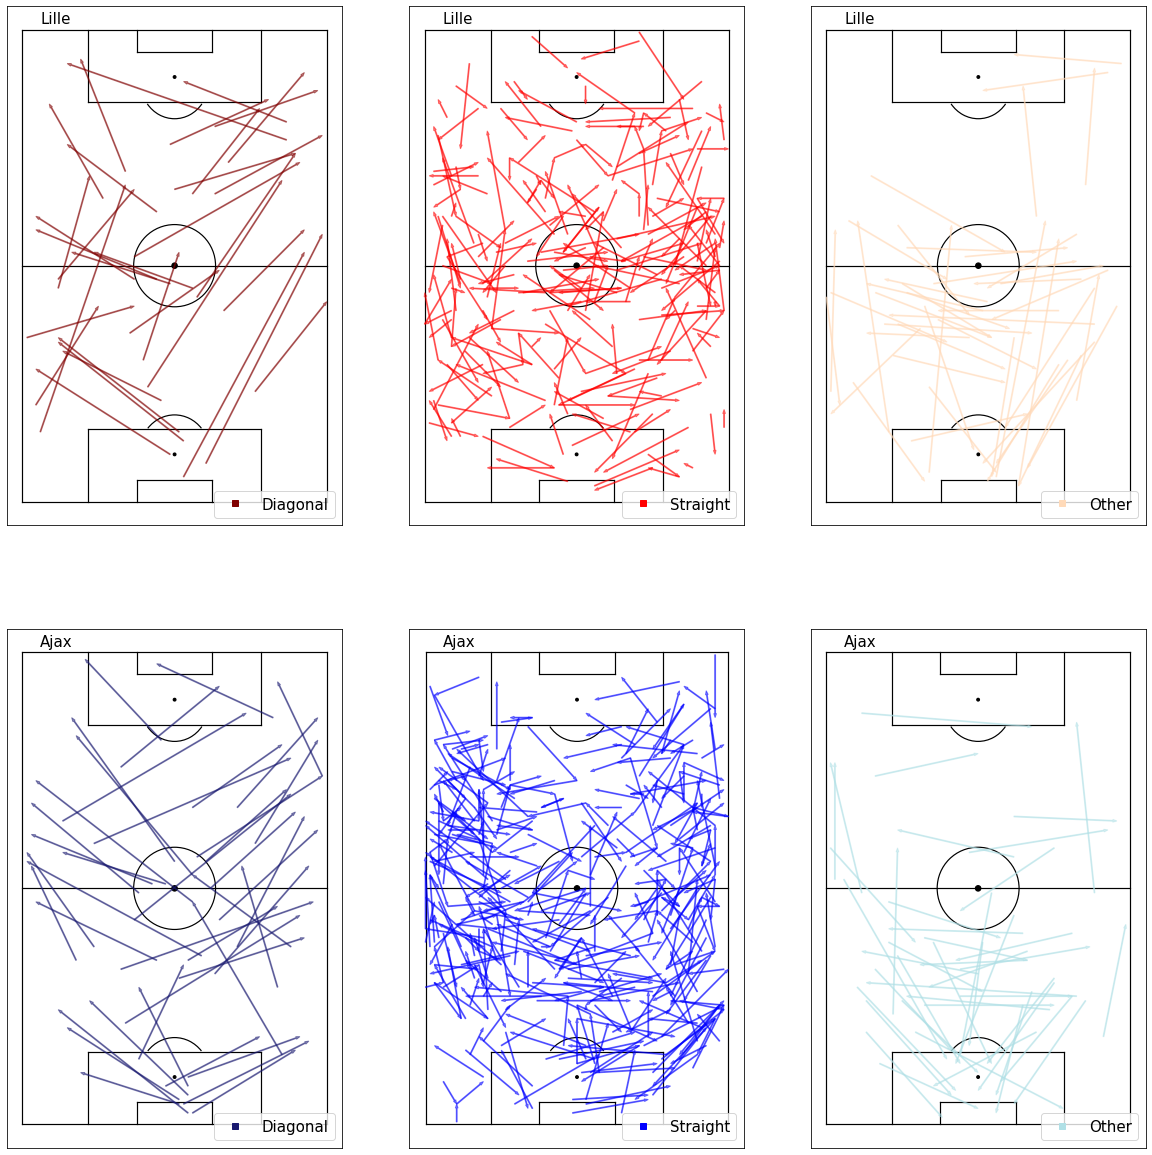

In [22]:
pass_plotter(diagonal_passes, straight_passes, other_passes, team1_id, team2_id)